# topic 3


- growth in bike use
    1. bike use growth measureing (1.willingness function) (limit: the willingess function is not completely correct, when the distance is adequatedly short poeple's willingness to walking will increase, with to biking decreasing)
- bicycle network optimize

 Analysis: 
 - what's people main purpose of traveling? (grocery, work, wandelen)
 - what's people's main transportation? (nearly auto for all purpose, except wandelen (walking) and education(bike))
 - relation between people's purpose and transportation choosing.

data:
- Below are all data used in this topic, please change the path to your local path, when running the code.
- all data files are submitted

In [ ]:
import pandas as pd
import geopandas as gpd
import fiona


all_data_paths = [r"D:\OneDrive\Courses\Design of AI-driven business solution\on the road\OdiN 2019-2023\OdiN 2019\ODiN2019_Databestand_v2.0.csv",
                 r"D:\OneDrive\Courses\Design of AI-driven business solution\on the road\OdiN 2019-2023\OdiN 2020\ODiN2020_Databestand_v2.0.csv",
                 r"D:\OneDrive\Courses\Design of AI-driven business solution\on the road\OdiN 2019-2023\OdiN 2021\ODiN2021_Databestand.csv",
                 r"D:\OneDrive\Courses\Design of AI-driven business solution\on the road\OdiN 2019-2023\OdiN 2022\ODiN2022_Databestand.csv",
                 r"D:\OneDrive\Courses\Design of AI-driven business solution\on the road\OdiN 2019-2023\OdiN 2023\ODiN2023_Databestand_output.csv"]

# Read and concatenate all CSV files in all_data_paths
all_data = pd.concat(
    [pd.read_csv(path, sep=';', encoding='latin1', low_memory=False) for path in all_data_paths],
    ignore_index=True
)


# grocery location data
grocery_data = gpd.read_file(r"D:\OneDrive\Courses\Design of AI-driven business solution\grocery.geojson")

# use 2023 geopackage data, more information available
map_path = r'd:\OneDrive\Courses\Design of AI-driven business solution\cbsgebiedsindelingen2016-2025\cbsgebiedsindelingen2023.gpkg'
buurt_map = gpd.read_file(map_path, layer='buurt_gegeneraliseerd')
buurt_centroids = gpd.read_file(r"D:\OneDrive\Courses\Design of AI-driven business solution\buurt_centroiden.gpkg")
buurt_centroids.drop(columns=['path'], inplace=True)  # Drop column not needed
bus_neighborhoods = pd.read_csv(r"D:\OneDrive\Courses\Design of AI-driven business solution\bus_naar_buurt_fiets.csv",sep=';')
bus_centroids = gpd.read_file(r"D:\OneDrive\Courses\Design of AI-driven business solution\bushaltes.gpkg")
train_centroids = gpd.read_file(r"D:\OneDrive\Courses\Design of AI-driven business solution\trainstations.gpkg")
business_points = gpd.read_file(r"D:\OneDrive\Courses\Design of AI-driven business solution\ibis_centroiden.gpkg")

In [874]:
motiefv_rvm = all_data[['MotiefV', 'Rvm']].dropna()
motiefv_rvm = motiefv_rvm.replace('#NULL!', pd.NA).dropna()  # Replace '#NULL!' with NaN
motiefv_rvm.reset_index(drop=True, inplace=True) 
motiefv_rvm['Rvm'] = pd.to_numeric(motiefv_rvm['Rvm'], errors='coerce')  # Convert Rvm to numeric, coercing errors to NaN
motiefv_rvm['MotiefV'] = pd.to_numeric(motiefv_rvm['MotiefV'], errors='coerce')  # Convert MotiefV to numeric, coercing errors to NaN



# map MotiefV values to their corresponding labels
motiefv_rvm['MotiefV'] = motiefv_rvm['MotiefV'].map({
    1: 'work (from and to)',
    2: 'Business visit',
    3: 'Professional',
    4: 'Pick up/drop off people',
    5: 'Pick up/drop off goods',
    6: 'Education',
    7: 'Shopping/Groceries',
    8: 'Visiting/overnighting',
    9: 'Touring/walking',
    10: 'Sport/hobby',
    11: 'Other leisure activities',
    12: 'Personal care/services',
    13: 'Other purpose'
})

# map Rvm values to their corresponding labels
motiefv_rvm['Rvm'] = motiefv_rvm['Rvm'].map({
    1: 'Personenauto',
    2: 'Trein',
    3: 'Bus',
    4: 'Tram',
    5: 'Metro',
    6: 'Speedpedelec',
    7: 'Elektrische fiets',
    8: 'Niet-elektrische fiets',
    9: 'Te voet',
    10: 'Touringcar',
    11: 'Bestelauto',
    12: 'Vrachtwagen',
    13: 'Camper',
    14: 'Taxi/Taxibusje',
    15: 'Landbouwvoertuig',
    16: 'Motor',
    17: 'Bromfiets',
    18: 'Snorfiets',
    19: 'Gehandicaptenvervoermiddel met motor',
    20: 'Gehandicaptenvervoermiddel zonder motor',
    21: 'Skates/skeelers/step',
    22: 'Boot',
    23: 'Anders met motor',
    24: 'Anders zonder motor'
})

del all_data

Text(70.7222222222222, 0.5, 'MotiefV')

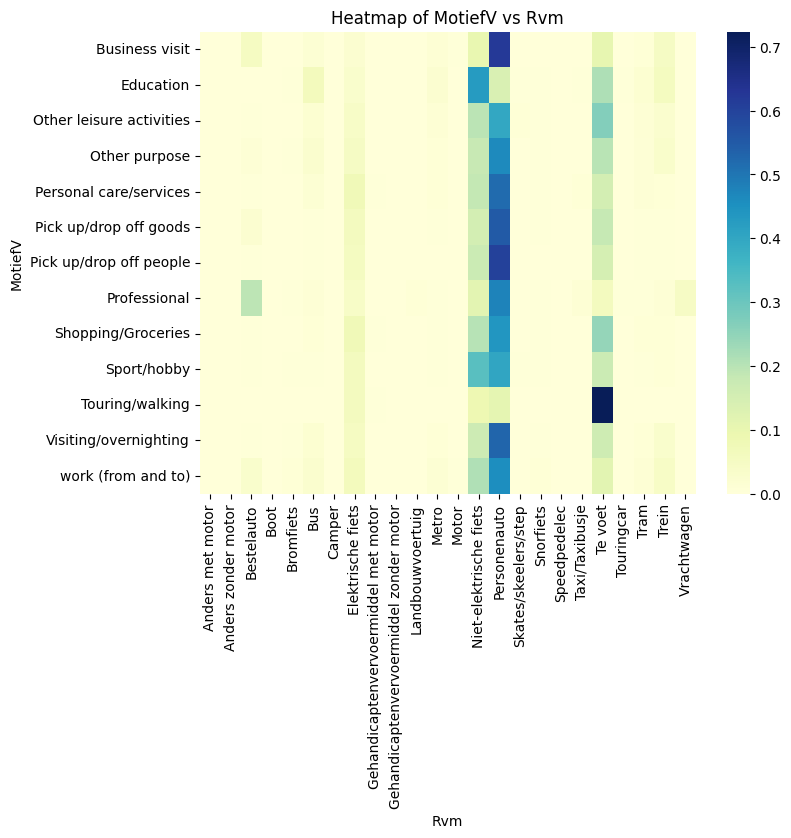

In [996]:
# plot heat map of MotiefV vs Rvm
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(motiefv_rvm['MotiefV'], motiefv_rvm['Rvm'], normalize='index'), cmap='YlGnBu')
plt.title('Heatmap of MotiefV vs Rvm')
plt.xlabel('Rvm')
plt.ylabel('MotiefV')

correlation between purpose and transportation choice:
- grocery: 80% auto, 10% bike, 10% walking
- work: 60% auto, 30% bike, 10% walking
- leisure: 50% auto, 40% bike, 10% walking
- education: 20% auto, 70% bike, 10% walking
- walking: 10% auto, 20% bike, 70% walking

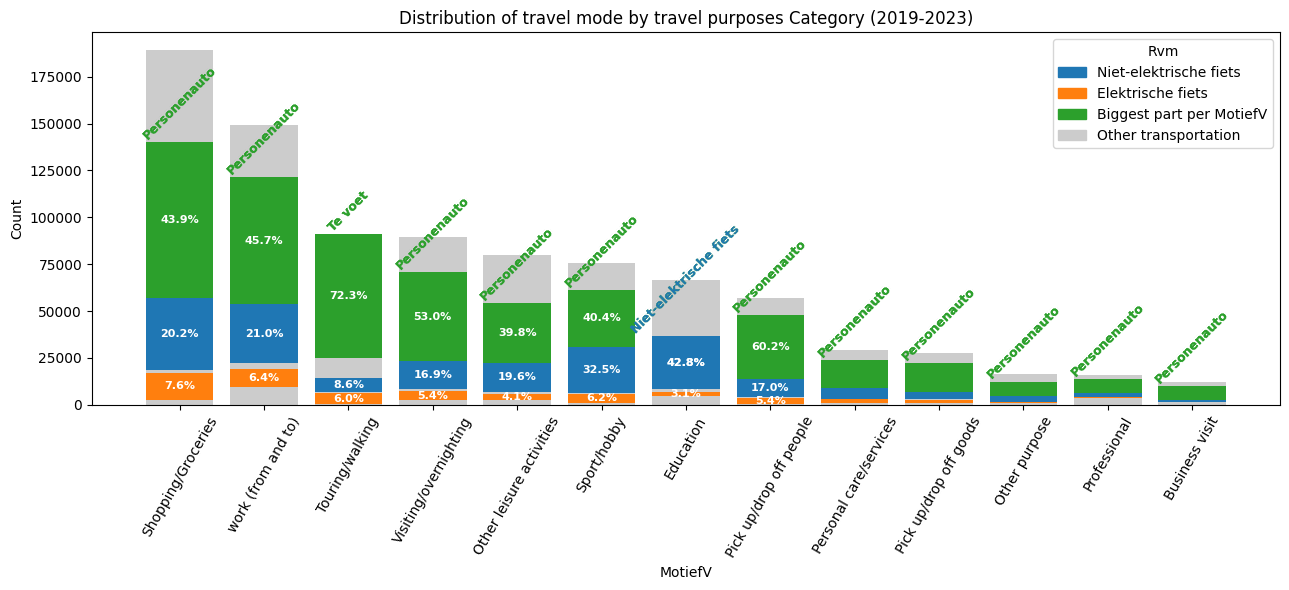

In [875]:
import matplotlib.pyplot as plt

# Plot, but only color bars for 'Niet-elektrische fiets' (8) and 'Elektrische fiets' (7)
ct = motiefv_rvm.groupby('MotiefV')['Rvm'].value_counts().unstack().fillna(0)
# order the bars by the order of quantity of MotiefV from the biggest to the smallest
ct = ct.reindex(ct.sum(axis=1).sort_values(ascending=False).index)

# Find the biggest part in each MotiefV (column-wise max)
max_rvm_per_motiefv = ct.idxmax(axis=1)

# Define colors for each Rvm column
def get_colors(ct):
    colors = []
    for col in ct.columns:
        if col == 'Elektrische fiets':
            colors.append('#ff7f0e')  # orange
        elif col == 'Niet-elektrische fiets':
            colors.append('#1f77b4')  # blue
        else:
            colors.append('#cccccc')  # gray
    return colors

# Build color matrix: highlight 'Elektrische fiets', 'Niet-elektrische fiets', and the biggest part per MotiefV
color_matrix = []
for i, motiefv in enumerate(ct.index):
    row_colors = []
    max_rvm = max_rvm_per_motiefv[motiefv]
    for col in ct.columns:
        if col == 'Elektrische fiets':
            row_colors.append('#ff7f0e')
        elif col == 'Niet-elektrische fiets':
            row_colors.append('#1f77b4')
        elif col == max_rvm:
            row_colors.append('#2ca02c')  # green for the biggest part
        else:
            row_colors.append('#cccccc')
    color_matrix.append(row_colors)

# Prepare legend handles
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='#1f77b4', label='Niet-elektrische fiets'),
    mpatches.Patch(color='#ff7f0e', label='Elektrische fiets'),
    mpatches.Patch(color='#2ca02c', label='Biggest part per MotiefV'),
    mpatches.Patch(color='#cccccc', label='Other transportation')
]

# Plot each MotiefV as a stacked bar with custom colors
plt.figure(figsize=(13, 6))
bottom = None
bars = []
for idx, col in enumerate(ct.columns):
    color_list = [color_matrix[i][idx] for i in range(len(ct))]
    bar = plt.bar(ct.index, ct[col], bottom=bottom, color=color_list, label=col if col in ['Elektrische fiets', 'Niet-elektrische fiets'] else None)
    bars.append(bar)
    if bottom is None:
        bottom = ct[col].values
    else:
        bottom = bottom + ct[col].values

# Add the biggest part of 'transportation name' as text for each MotiefV
for i, motiefv in enumerate(ct.index):
    max_rvm = max_rvm_per_motiefv[motiefv]
    max_val = ct.loc[motiefv, max_rvm]
    # Find the position (bottom) for the label
    col_idx = list(ct.columns).index(max_rvm)
    y_pos = ct.iloc[i, :col_idx+1].sum()
    plt.text(i, y_pos, max_rvm, ha='center', va='bottom', fontsize=9, color='#2ca02c', fontweight='bold', rotation = 45)
    # change the color of the text to match the biggest part
    plt.text(i, y_pos, max_rvm, ha='center', va='bottom', fontsize=9, color=color_matrix[i][col_idx], fontweight='bold', rotation=45)
    # add the percentage of niet-elektrische fiets, elektrische fiets and the biggest part for each MotiefV
    total_count = ct.iloc[i].sum()

    # Only annotate for the first (len(ct) - 5) MotiefV categories (beacuse the last 5 motivation are not significant in majority)
    if i < len(ct) - 5:
        if total_count > 0:
            percentage_ne_fiets = (ct.loc[motiefv, 'Niet-elektrische fiets'] / total_count) * 100
            percentage_e_fiets = (ct.loc[motiefv, 'Elektrische fiets'] / total_count) * 100
            text_y = y_pos - (max_val / 2)
            if ct.loc[motiefv, 'Niet-elektrische fiets'] > 0:
                ne_y = ct.iloc[i, :list(ct.columns).index('Niet-elektrische fiets')+1].sum() - ct.loc[motiefv, 'Niet-elektrische fiets']/2
                plt.text(i, ne_y, f'{percentage_ne_fiets:.1f}%', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
            if ct.loc[motiefv, 'Elektrische fiets'] > 0:
                e_y = ct.iloc[i, :list(ct.columns).index('Elektrische fiets')+1].sum() - ct.loc[motiefv, 'Elektrische fiets']/2
                plt.text(i, e_y, f'{percentage_e_fiets:.1f}%', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
            if max_val > 0:
                plt.text(i, text_y, f'{(max_val / total_count) * 100:.1f}%', ha='center', va='center', fontsize=8, color='white', fontweight='bold')



# plt.bar(ct.index, ct.sum(axis=1), color='lightgray', label='Total per MotiefV', alpha=0.5)
plt.title('Distribution of travel mode by travel purposes Category (2019-2023)')
plt.xlabel('MotiefV')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.legend(handles=legend_handles, title='Rvm', loc='upper right')
plt.tight_layout()
plt.show()

1. most peopel travel to shopping/grocery, but with near half of the participant going by car, only 20.2 + 7.6% by bike( + e). 
2. it's the similar situation with work.
3. Touring is reasonable, for hiking, walking
4. for education purpose, there is still space to increase peoples bike usage, even though the most common transportantion is bike, but still more than half are choosing other traveling tool. 

##### increasing bike usage of traveling for shopping/grocery 
- from neighborhood to business place (we're using the single instead of serial trip data from ODin so we're more confident to assume participants leaving from home to business district for shopping/grocery) 

In [880]:
# join buurt_map and buurt_centroids on jrstatcode, add the geometry from buurt_map to buurt_centroids
buurt_map = buurt_centroids.merge(buurt_map[['jrstatcode', 'geometry']], on='jrstatcode', how='left')

del buurt_centroids  # Drop the original buurt_centroids to save memory

D:\temp\ipykernel_22476\567903609.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


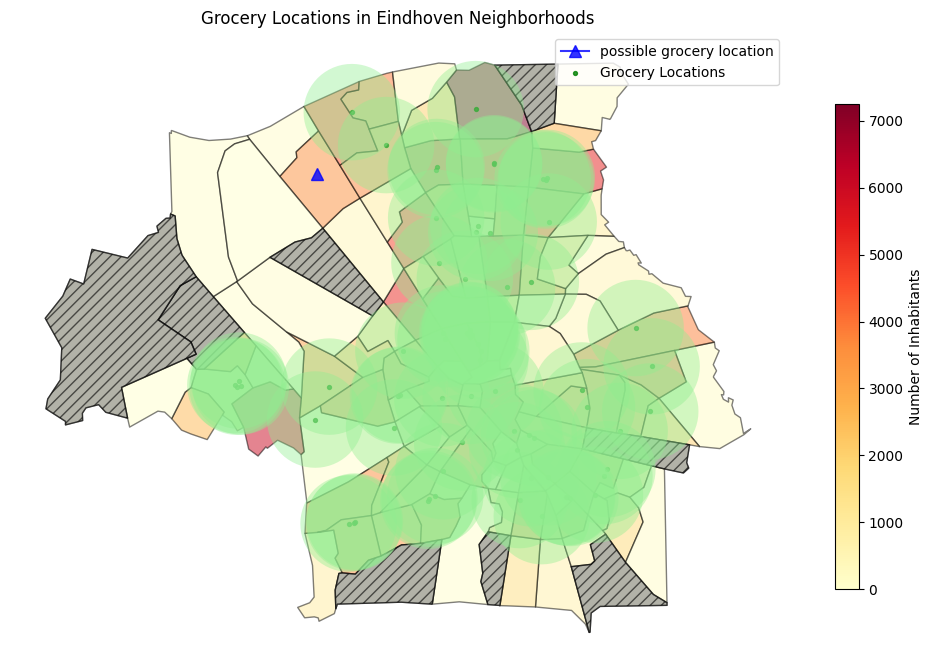

In [882]:
# Select Eindhoven neighborhoods
eindhoven_buurt_map = gpd.GeoDataFrame(buurt_map[buurt_map['gm_naam'] == 'Eindhoven'])
eindhoven_buurt_map.reset_index(inplace=True)
# Set the active geometry column after resetting the index
eindhoven_buurt_map = eindhoven_buurt_map.set_geometry('geometry_y')
# plot the neighborhoods of Eindhoven
# plot heat map of number of inhabitants (aant_inw) in Eindhoven neighborhoods
# Plot the neighborhoods of Eindhoven, coloring by number of inhabitants
ax = eindhoven_buurt_map.plot(
    column='aant_inw',
    cmap='YlOrRd',
    figsize=(10, 10),
    edgecolor='black',
    alpha=0.5,
    legend_kwds={'shrink': 0.5, 'label': "Number of Inhabitants"},
    legend=True
)

# Add shade for areas with less than 25 inhabitants 1/10 000 of total population
eindhoven_buurt_map[eindhoven_buurt_map['aant_inw'] < 25].plot(
    ax=ax,
    color='gray',
    alpha=0.6,
    edgecolor='black',
    hatch='///',
    label='aant_inw < 5'
)

# add triangle markers to Grasrijk, Kerkdorp Acht bu_naam.
for x, y, possible_grocery in zip(eindhoven_buurt_map.geometry_x.centroid.x, 
                       eindhoven_buurt_map.geometry_x.centroid.y, 
                       eindhoven_buurt_map['bu_naam']):
    if possible_grocery in ['Kerkdorp Acht']:
        plt.plot(x, y, marker='^', color='blue', markersize=8, alpha=0.8, label='possible grocery location')


# convert reference system of grocery_data to match buurt_map
grocery_data = grocery_data.to_crs(eindhoven_buurt_map.crs)
# plot the grocery locations on the map of Eindhoven neighborhoods
# Plot grocery locations
grocery_data.plot(ax=plt.gca(), alpha=0.8, 
                  marker='o', color='green', markersize=8, label='Grocery Locations')

# Add 913m buffer (light green shade) around each grocery location
grocery_buffers = grocery_data.copy()
grocery_buffers['geometry'] = grocery_buffers.geometry.buffer(913)  # 913 meters
grocery_buffers.plot(ax=plt.gca(), color='lightgreen', alpha=0.4, label='913m Buffer')
plt.title('Grocery Locations in Eindhoven Neighborhoods')

plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()


For improving people's willingness to use bike when going for grocery, investing new grocery stores are suggested. Beacuse investing in new cycle lines is much more costly than incourage to invest in a new grocery store.
Due to our limited informaction of distance from neighborhood to nearest grocery store, according to anlysis we do, we would suggest to invest new grocery stores in **Kerkdorp Acht**, for the reason of high population and lacking of grocery store nearby (15km/h (25% quantile speed, buurt_naar_buurts data), 75% willingness, 4.5mins biking, 1125m in total, average 1.23 detour factor, circle of 913m ).

##### going to and from work willingness to bike improving

GOAL: all business park to train station, bus halt, neighborhood should be within high willingness(86.7% upper bound of efficient improving, detailed analysis is later ) of bike distance if it's possible. <br>
high variation of people's residential location and work location (within city, across city...). <br>
so here we suggest to make sure all business parks are reachable by bus/ train/ bike.  <br>
Assuming public transport are highly connected, every public transport station(train station, bus stop) is reacheable within the network of public transport.(we know that whereof train station is, thereor bus halt is within walking distance. Moreover, according to willingness function, people are more tolerant to longer distance when biking to train stations than to bus stops.  so we can leave off the trein_naar_buurts, just reducing workload. Logically, we considered train station) Therefore, employees going to work only need to consider the first modal of leaving home (from neighborhoods to train station/ bus stop if needed. or merely bike to work location )and the last modal of arriving to business park (from train station/ bus stop/ from neighborhoods). <br>
    - neighborhoods to at least one public transport location achieving 86.7% of willingness to bike <br>
    - business park to at least one public transport location achieving 86.7% of willingness to bike <br>


**We know that people's willingness to bike is associated with traveling time, such that there are two kinds of situations when willingness is low.** I.e. <br> 
1. long distance
    - possible reason: detour
    - solution: reroute, build new bike routes
    - cost: high (environmental impact and architectural design)
    - also might be high, frequent slopes, but this is also costly to deal with

2. slow speed of biking;
    - possible reason: interruptions from pedestrian or driveways crossing, long waiting time for signalization, low quality of routes, unclear signage,
    - solution: implement bicycle-friendly signalization, build protected bike lanes, protected intersections, upgrade pavemenets, increasing road signage for biking recuding hesitation.
    - cost: low 

In [ ]:
# drop rows where 'bu_code' or 'reistijd_min' is NaN to avoid KeyError
bus_neighborhoods = bus_neighborhoods.dropna(subset=['bu_code', 'reistijd_min'])
# drop duplicate rows based on bu_code, keep the smallest value of 'reistijd_min' for each bu_code
bus_neighborhoods = bus_neighborhoods.loc[bus_neighborhoods.groupby('bu_code')['reistijd_min'].idxmin()]

##### Netherlands

In [ ]:
# add 'omrijdfactor_bus', 'reistijd_min_bus' column to buurt_map, according to bus_neighborhoods
buurt_map = buurt_map.merge(bus_neighborhoods[['bu_code', 'omrijdfactor', 'reistijd_min','reisafstand_m','afstand_hemelsbreed_m']], on='bu_code', how='left')
buurt_map.rename(columns={'omrijdfactor': 'omrijdfactor_bus', 'reistijd_min': 'reistijd_min_bus','reisafstand_m': 'reisafstand_m_bus', 'afstand_hemelsbreed_m': 'afstand_hemelsbreed_m_bus'}, inplace=True)

#calculate the speed for biking to nearest bus stop from each buurt
buurt_map['speed_bus_bike_km_hour'] = (buurt_map['reisafstand_m_bus']/1000) / (buurt_map['reistijd_min_bus']/60)
buurt_map['ristijnd_min_bus_lower_bound'] = buurt_map['afstand_hemelsbreed_m_bus'] / 1000 / 18 * 60  # assuming average speed of 18 km/h from data
buurt_map = gpd.GeoDataFrame(buurt_map, geometry='geometry_y')


- calculate the current willingness to bike (data: traveling time, Willingness function provided)
- calculate the willingness upper bound, crow fly traveling time lower bound (with crow fly distance, assuming speed of 18km/h ---  mean value of biking speed of bus_naar_buurt data )

In [885]:
import numpy as np

def willingness_function(t, a=-5.744, b=2.633):
    """
    Willingness function F(t) = [1 + exp(a + b * ln(t))]^-1
    t: time (can be scalar or numpy array)
    Returns: willingness value(s)
    """
    t = np.asarray(t)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = 1 / (1 + np.exp(a + b * np.log(t)))
        result = np.where(t > 0, result, 0)  # Set willingness to 0 for t <= 0
    return result
# Calculate willingness to bike to bus stop based on reistijd_min_bus
buurt_map['willingness_bus_current'] = willingness_function(buurt_map['reistijd_min_bus'])
buurt_map['willingness_bus_upper_bound'] = willingness_function(buurt_map['ristijnd_min_bus_lower_bound'])
# deal with reistijd_min_bus being 0 beacuse of short distance to bus stop, so that willingness equals willingness_bus_upper_bound
buurt_map.loc[buurt_map['reistijd_min_bus'] == 0, 'willingness_bus_current'] = buurt_map['willingness_bus_upper_bound']


D:\temp\ipykernel_22476\4025040339.py:9: RuntimeWarning: divide by zero encountered in log
  exp_term = np.exp(a + b * np.log(t))
D:\temp\ipykernel_22476\4025040339.py:12: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


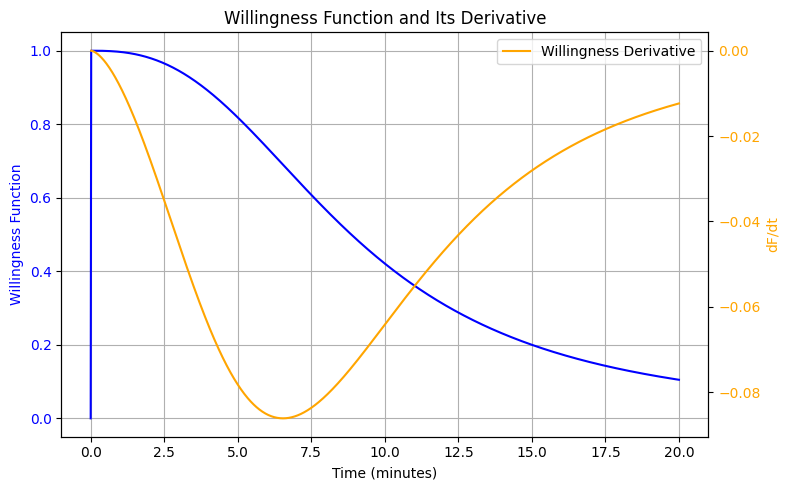

the most effective decreasing interval of traveling time for bike usage improvement is at: [4.35362802 9.35779817] minutes
Willingness value at this time: [0.86655451 0.46407675]


In [886]:
def willingness_function_derivative(t, a=-5.744, b=2.633):
    """
    Derivative of the willingness function F(t) with respect to t:
    F(t) = [1 + exp(a + b * ln(t))]^-1

    dF/dt = -b * exp(a + b*ln(t)) / [t * (1 + exp(a + b*ln(t)))^2]
    """
    t = np.asarray(t)
    exp_term = np.exp(a + b * np.log(t))
    denominator = t * (1 + exp_term) ** 2
    numerator = -b * exp_term
    return numerator / denominator

# plot the willingness_function_derivative


# Generate a range of time 0 to 20 mins
time = np.linspace(0, 20, 1200)  # Time in minutes
# Calculate the willingness function derivative for these times
willingness_derivative = willingness_function_derivative(time)
# plot the willingness function on the same graph with right y-axis
plt.figure(figsize=(8, 5))
plt.plot(time, willingness_function(time), label="Willingness Function", color='blue')
plt.title("Willingness Function and Its Derivative")
plt.xlabel("Time (minutes)")
plt.ylabel("Willingness Function", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.grid()
plt.twinx()  # Create a second y-axis
plt.plot(time, willingness_derivative, label="Willingness Derivative", color='orange')
plt.ylabel("dF/dt", color='orange')
plt.tick_params(axis='y', labelcolor='orange')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



pd.Series(willingness_derivative).describe()
# get the value of time where willingness derivative equals -0.07, which is the top 25% effective decreasing interval of traveing time for bike usage improving
percentile_25 = np.quantile(willingness_derivative[~np.isnan(willingness_derivative)], 0.25)
# Find the time(s) where the derivative is close to this value
close_indices = np.isclose(willingness_derivative, percentile_25, atol=1e-4)
print(f"the most effective decreasing interval of traveling time for bike usage improvement is at: {time[close_indices]} minutes")
# print the value of willingness value at this time
willingness_value_at_percentile_25 = willingness_function(time[close_indices])
print(f"Willingness value at this time: {willingness_value_at_percentile_25}")


In [887]:
# calculate smallest derivative of willingness
smallest_derivative = np.min(willingness_derivative[~np.isnan(willingness_derivative)])
print(f"Smallest derivative of willingness: {smallest_derivative}")
# Find the time(s) where the derivative is close to this value
close_indices_smallest = np.isclose(willingness_derivative, smallest_derivative)
print(f"The smallest derivative of willingness is at: {time[close_indices_smallest]} minutes")
# print the value of willingness value at this time
willingness_value_at_smallest = willingness_function(time[close_indices_smallest])
print(f"Willingness value at this time: {willingness_value_at_smallest}")

Smallest derivative of willingness: -0.08613982121347548
The smallest derivative of willingness is at: [6.53878232 6.55546289] minutes
Willingness value at this time: [0.68994918 0.68851232]


- according to the derivative function, in the interval of [4.35, 9.36] minutes, the willingness is most efficiently improved by traveling time decreasing.<br> 
the willingness would increase from 46.4% to 86.7%

Define how promissing a location is for improvement:
1. from the Willingness function we can integret that wrt. travling time, it's most efficient to improve biking usage between 46.4% and 86.7% willingess, where the biking time is between [4.34, 9.36] minutes.

> perhaps a graph to present

**Identify promissing improvement**:
efficient interval of improvent willingness between [46.4%, 86.7%]
construct 'reason' column: 
- if willingness upper bound = 0 : **lacking data or unexpected value'8'**
- current willingness> 86.7%, already high willingness,  no need to improve, **model area '0'**
- 46.4% < current willingness < 68.9%:
    - willingness upper bound> current willingness:  **highly promissing project**
- 68.9% < current willingness < 86.7%:
    - willingness upper bound > current willingness : **promissing projects '4'** alreay with respectively high willingness
- current willingness < 46.4%
    - willingnes upper bound = current willingness: not possible to improve, alreay the best can get eventhough maybe not satisfying or satisfying, **non-project '1'** 
    - 2 willingness upper bound< 46.4%: **unwise project'2'**, after improvement still low willingness, and within inefficient interval 
    - 3 willingness upper bound > 46.4% **possible project'3'**, within inefficient interval


Then classify the highly promissing project by low willingness reason: <br>
for highly promissing project, if speed_bus_bike_km_hour>= 15: **long distance'5'**, if speed_bus_bike_km_hour< 13: **slow speed'6'**.
else, is for both, **long distance and slow speed'7'**.

In [907]:
def classify_reason(row):
    curr = row['willingness_bus_current']
    upper = row['willingness_bus_upper_bound']
    speed = row.get('speed_bus_bike_km_hour', None)
    # lacking data or unexpected value
    if upper == 0:
        return '8'
    # already high willingness, no need to improve
    if curr > 0.867:
        return '0'
    # highly promising project: efficient interval, upper > curr
    if 0.464 < curr < 0.689 and upper > curr:
        if speed is not None:
            if speed >= 15:
                return '5'  # long distance
            elif speed < 13:
                return '6'  # slow speed
            else:
                return '7'  # both long distance and slow speed
        else:
            return '7'
    # promising project: already with respectively high willingness
    if 0.689 <= curr < 0.867 and upper > curr:
        return '4'
    # inefficient interval
    if curr < 0.464:
        if upper == curr:
            return '1'  # non-project, already best possible
        elif upper < 0.464:
            return '2'  # unwise project
        elif upper > 0.464:
            return '3'  # possible project, within inefficient interval
    return '8'  # fallback for other cases

buurt_map['reason'] = buurt_map.apply(classify_reason, axis=1)


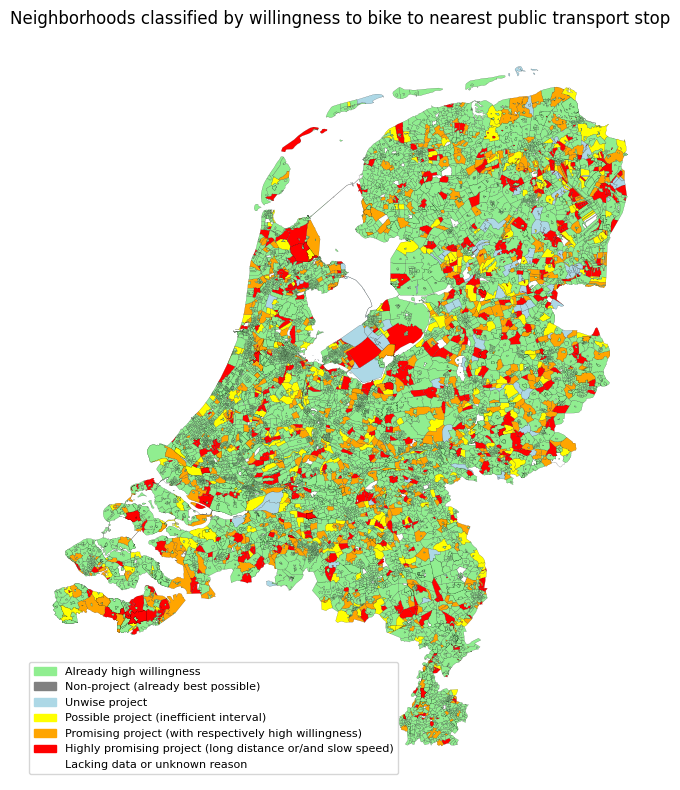

In [908]:
# Plot neighborhoods colored by 'reason', with promissing projects (reason '5' and '6') in the same color
import matplotlib.patches as mpatches

# Define color mapping for each reason
reason_colors = {
    '0': 'lightgreen',   # already high willingness
    '1': 'grey',         # non-project, already best possible
    '2': 'lightblue',    # unwise project
    '3': 'yellow',       # possible project, but inefficient interval
    '4': 'orange',       # promising project, already with respectively high willingness
    '5': 'red',          # highly promising project: long distance
    '6': 'red',          # highly promising project: slow speed (same as '5')
    '7': 'red',          # highly promising project: both long distance and slow speed (same as '5' and '6')
    '8': 'white'       # lacking data or unknown reason
}

# Map colors to the DataFrame
buurt_map['reason_color'] = buurt_map['reason'].map(reason_colors).fillna('white')

fig, ax = plt.subplots(figsize=(10, 8))
buurt_map.plot(color=buurt_map['reason_color'], ax=ax, edgecolor='black', linewidth=0.1)

# Custom legend
legend_patches = [
    mpatches.Patch(color='lightgreen', label='Already high willingness'),
    mpatches.Patch(color='grey', label='Non-project (already best possible)'),
    mpatches.Patch(color='lightblue', label='Unwise project'),
    mpatches.Patch(color='yellow', label='Possible project (inefficient interval)'),
    mpatches.Patch(color='orange', label='Promising project (with respectively high willingness)'),
    mpatches.Patch(color='red', label='Highly promising project (long distance or/and slow speed)'),
    mpatches.Patch(color='white', label='Lacking data or unknown reason')
]

plt.legend(handles=legend_patches, loc='lower left', fontsize=8)
plt.title("Neighborhoods classified by willingness to bike to nearest public transport stop")
plt.axis('off')
plt.tight_layout()
plt.show()

focusing on highly promissing projects

D:\temp\ipykernel_22476\2795363949.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=8)


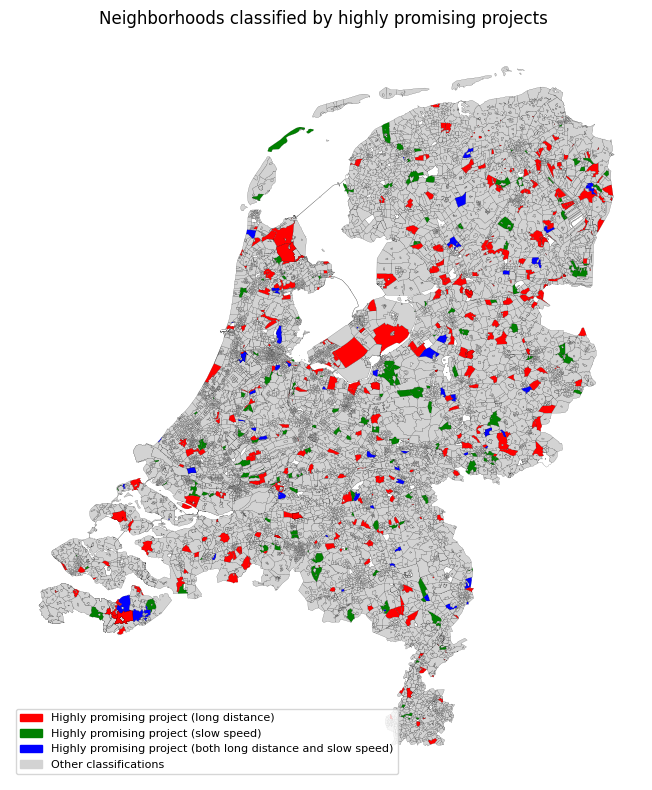

In [909]:
# Plot buurt map with reason classification: '6' (slow speed) in green, '5' (long distance) in red, others in grey
fig, ax = plt.subplots(figsize=(10, 8))
# Define colors for '5' and '6'
dis_highly_colors = {
    '5': 'red',      # long distance (promising)
    '6': 'green',    # slow speed (promising)
    '7': 'blue',      # highly promising project: both long distance and slow speed
    '0': 'lightgrey',
    '1': 'lightgrey',
    '2': 'lightgrey',
    '3': 'lightgrey',
    '4': 'lightgrey',  # promising project, already with respectively high willingness
    '8': 'white'       # lacking data or unknown reason
}
# Map colors to the DataFrame
buurt_map['dis_highly_color'] = buurt_map['reason'].map(dis_highly_colors).fillna('white')
# Plot the neighborhoods with the specified colors
buurt_map.plot(color=buurt_map['dis_highly_color'], ax=ax, edgecolor='black', linewidth=0.1)

plt.legend(loc='upper left', fontsize=8)
plt.title("Neighborhoods classified by highly promising projects ")
plt.legend(handles=[
    mpatches.Patch(color='red', label='Highly promising project (long distance)'),
    mpatches.Patch(color='green', label='Highly promising project (slow speed)'),
    mpatches.Patch(color='blue', label='Highly promising project (both long distance and slow speed)'),
    mpatches.Patch(color='lightgrey', label='Other classifications')
], loc='lower left', fontsize=8)
plt.axis('off')
plt.tight_layout()
plt.show()

##### highly promissing projects importance anlyasis based on estimated total number of trips increasing for each neiborhoods

1. total number of trips for each neighborhood per day is defined as: <br>
 ( 2(twice a day)* employees amount in the business park within the neborhood +  2 * working residents amount * 0.8 (assuming 80% needs to travel to work to bus/ train/ business park)) *3.5/5 (hybrid working) :    define column: influencing trips

2. estimate total number of trips increasing per day is defined as: <br>
 influencing trips * (willingness increasing) <br>
 willingness increasing is definded as: <br>
    - for slow speed:  willingness function of (current distance/ 18km/h(improved speed)) - current willingness
    - for long distance: willingness function of (crow fly distance/(current speed)) - current willingness
    - for both: willingness function of (crow fly distance/(max(current speed, 18km/h)) - current willingness 
3. estimate employees amount for business park <br>
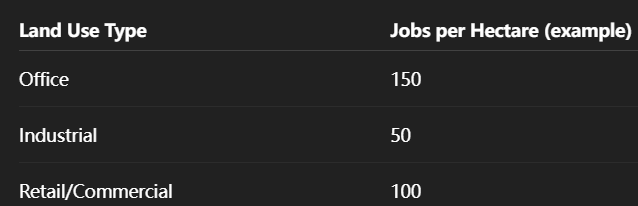 
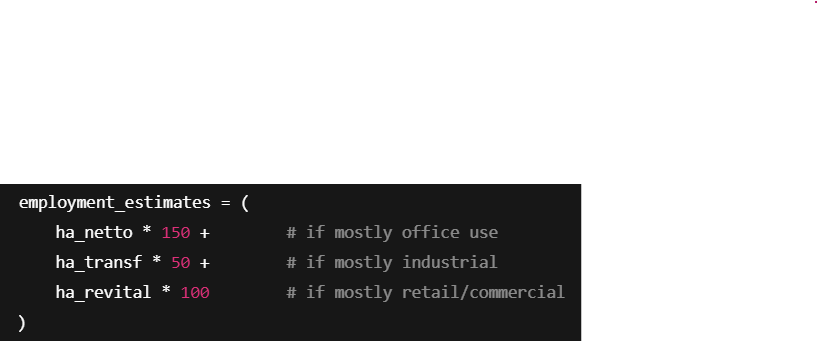

4. estimate working residents amount: <br>
Assume working age is 15-64, columns 'p_15_24_jr', 'p_25_44_jr', 'p_45_64_jr' exist in buurt_map, with percentage of 50%, 95%, 95% respectively working

- calculate the total number of trips for each neighborhood

In [ ]:
# find the neighborhoods each business point is located in
business_points['bu_code'] = business_points.geometry.apply(lambda x: buurt_map[buurt_map.contains(x)].bu_code.iloc[0] if not buurt_map[buurt_map.contains(x)].empty else None)

# calculate the employement_estimation for business park
business_points['employment_estimation'] = (
    business_points['ha_netto'] * 150 +        # if mostly office use
    business_points['ha_transf'] * 50 +        # if mostly industrial
    business_points['ha_revital'] * 100        # if mostly retail/commercial
)

business_points['employment_estimation'] = business_points['employment_estimation'].astype(int)  # Convert to integer

# add the employment_estimation to buurt_map, according to bu_code
buurt_map = buurt_map.merge(business_points[['bu_code', 'employment_estimation', 'coropcodes']], on='bu_code', how='left')
buurt_map.rename(columns={'employment_estimation': 'employement_estimation_corop'}, inplace=True)  # to avoid confusion with the total employment estimation for a neighborhood
# Fill NaN values in 'employment_estimation' with 0
buurt_map['employement_estimation_corop'] = buurt_map['employement_estimation_corop'].fillna(0).astype(int)

# Calculate total employment estimation for each neighborhood
buurt_map['total_employment_estimation'] = buurt_map.groupby('bu_code')['employement_estimation_corop'].transform('sum')


In [ ]:
# Replace -99999999.0 with 0, then calculate the number of working age residents
buurt_map[['p_15_24_jr', 'p_25_44_jr', 'p_45_64_jr']] = buurt_map[['p_15_24_jr', 'p_25_44_jr', 'p_45_64_jr']].replace(-99999999.0, 0)
# Assume working age is 15-64, columns 'p_15_24_jr', 'p_25_44_jr', 'p_45_64_jr' exist in buurt_map, with percentage of 50%, 95%, 96% respectively
buurt_map['working_residents'] = (
    buurt_map['p_15_24_jr'] / 100 * 0.5 * buurt_map['aant_inw'] +
    buurt_map['p_25_44_jr'] / 100 * 0.95 * buurt_map['aant_inw'] +
    buurt_map['p_45_64_jr'] / 100 * 0.96 * buurt_map['aant_inw']
)

# calculate the influencing trips for each neighborhood
buurt_map['influencing_trips_day'] = (
    2 * buurt_map['total_employment_estimation'] +
    2 * buurt_map['working_residents'] * 0.8
) * (3.5 / 5)

- calculate the estimated total number of trips increasing for each neighborhood

In [ ]:
# Calculate willingness increase for each neighborhood based on reason
def calc_willingness_increase(row):
    curr = row['willingness_bus_current']
    # For slow speed (reason '6'): use current distance with improved speed (18 km/h)
    if row['reason'] == '6':
        if row['reisafstand_m_bus'] > 0:
            improved_time = (row['reisafstand_m_bus'] / 1000) / 18 * 60  # minutes
            return willingness_function(improved_time) - curr
        else:
            return 0
    # For long distance (reason '5'): use crow fly distance with current speed
    elif row['reason'] == '5':
        if row['afstand_hemelsbreed_m_bus'] > 0 and row['speed_bus_bike_km_hour'] > 0:
            crowfly_time = (row['afstand_hemelsbreed_m_bus'] / 1000) / row['speed_bus_bike_km_hour'] * 60
            return willingness_function(crowfly_time) - curr
        else:
            return 0
    # For both (reason '7'): use crow fly distance with max(current speed, 18 km/h)
    elif row['reason'] == '7':
        if row['afstand_hemelsbreed_m_bus'] > 0:
            speed = max(row['speed_bus_bike_km_hour'], 18) if row['speed_bus_bike_km_hour'] > 0 else 18
            crowfly_time = (row['afstand_hemelsbreed_m_bus'] / 1000) / speed * 60
            return willingness_function(crowfly_time) - curr
        else:
            return 0
    else:
        return 0

buurt_map['willingness_increase'] = buurt_map.apply(calc_willingness_increase, axis=1)
buurt_map['potential_willingness'] = buurt_map['willingness_increase'] + buurt_map['willingness_bus_current']

# calculate the increasing trips for each neighborhood based on willingness increase
buurt_map['increasing_trips_day'] = (
    buurt_map['influencing_trips_day'] * buurt_map['willingness_increase'])

# calculate the percentage of trips increasing per neighborhood
buurt_map['increasing_trips_perct'] = buurt_map['increasing_trips_day'] / buurt_map['influencing_trips_day'] * 100

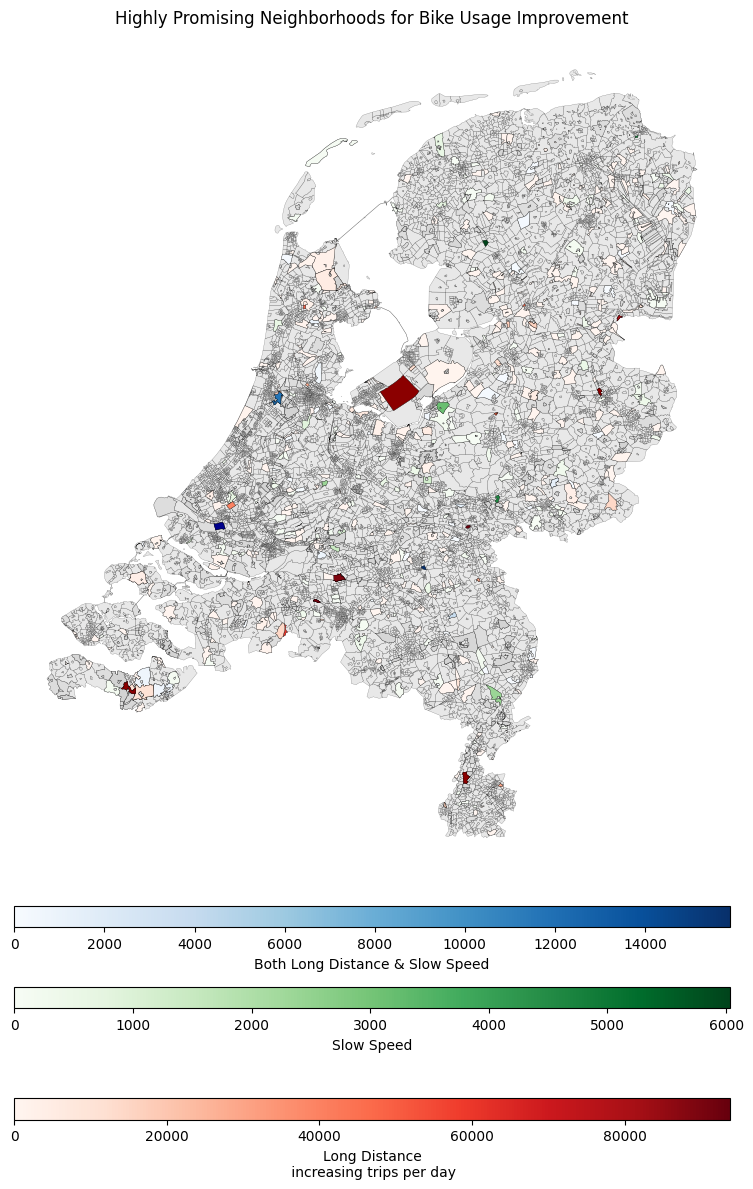

In [964]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(12, 12))

# Plot background
buurt_map.plot(color='lightgrey', edgecolor='black', linewidth=0.2, alpha=0.5, ax=ax)

# Plot '7' (both long distance and slow speed)
g7 = buurt_map[(buurt_map['reason'] == '7') & (~buurt_map['id'].isin([7119]))]
g7_plot = g7.plot(
    column='increasing_trips_day',
    cmap='Blues',
    ax=ax,
    edgecolor='black',
    linewidth=0.2,
    legend=False
)

# Plot outliers for '7'
buurt_map[buurt_map['id'].isin([7119])].plot(
    color='darkblue',
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)

# Plot '6' (slow speed)
g6 = buurt_map[buurt_map['reason'] == '6']
g6_plot = g6.plot(
    column='increasing_trips_day',
    cmap='Greens',
    ax=ax,
    edgecolor='black',
    linewidth=0.2,
    legend=False
)

# Plot '5' (long distance)
g5 = buurt_map[(buurt_map['reason'] == '5') & (~buurt_map['id'].isin([1340,12044,534,7798]))]
g5_plot = g5.plot(
    column='increasing_trips_day',
    cmap='Reds',
    ax=ax,
    edgecolor='black',
    linewidth=0.2,
    legend=False
)

# Plot outliers for '5'
buurt_map[buurt_map['id'].isin([1340,12044,534,7798])].plot(
    color='darkred',
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)

# Custom colorbars
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("bottom", size="2.5%", pad=0.3)
cax2 = divider.append_axes("bottom", size="2.5%", pad=0.6)
cax3 = divider.append_axes("bottom", size="2.5%", pad=0.9)

norm7 = mpl.colors.Normalize(vmin=g7['influencing_trips_day'].min(), vmax=g7['influencing_trips_day'].max())
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap='Blues', norm=norm7, orientation='horizontal')
cb1.set_label("Both Long Distance & Slow Speed")

norm6 = mpl.colors.Normalize(vmin=g6['influencing_trips_day'].min(), vmax=g6['influencing_trips_day'].max())
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap='Greens', norm=norm6, orientation='horizontal')
cb2.set_label("Slow Speed")

norm5 = mpl.colors.Normalize(vmin=g5['influencing_trips_day'].min(), vmax=g5['influencing_trips_day'].max())
cb3 = mpl.colorbar.ColorbarBase(cax3, cmap='Reds', norm=norm5, orientation='horizontal')
cb3.set_label("Long Distance\n increasing trips per day")

# Remove axis and set title
plt.sca(ax)
plt.title("Highly Promising Neighborhoods for Bike Usage Improvement")
plt.axis('off')
plt.tight_layout()
plt.show()

- top 10 highly promissing projects due to slow speed 

D:\temp\ipykernel_22476\310641353.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(highly_promising_speed_10['bu_naam'], rotation=30, ha='right')


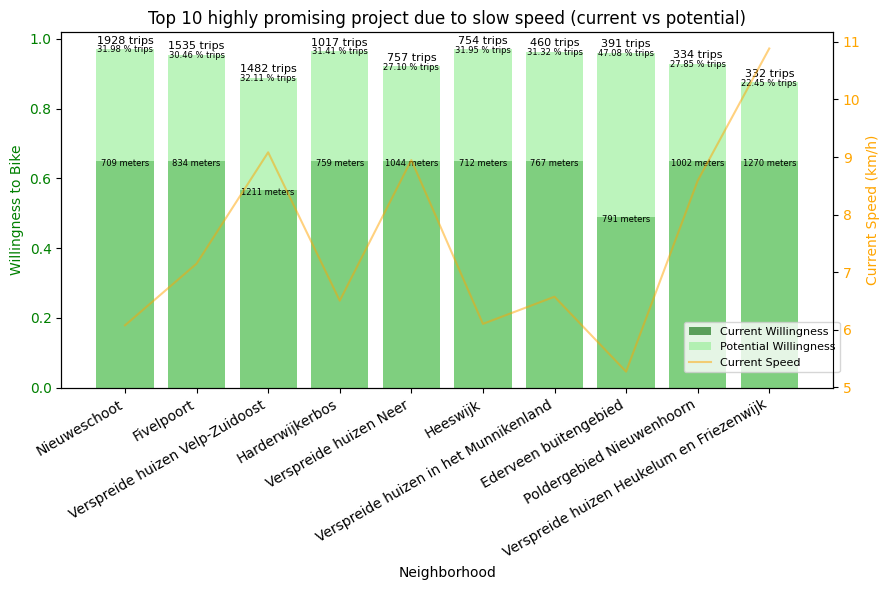

In [980]:
highly_promising_speed_10 = buurt_map[(buurt_map['reason'] == '6')].sort_values(by='increasing_trips_day', ascending=False).drop_duplicates('bu_code').head(10)

# plot the current willingness and willingness upper bound to bike to bus stop for the top 10 neighborhoods with the highest influencing trips with left y-axis
# plot the speed to bike to bus stop for the top 10 neighborhoods with the highest influencing trips with right y-axis
fig, ax1 = plt.subplots(figsize=(9, 6))
# Plot current willingness and upper bound willingness
ax1.bar(highly_promising_speed_10['bu_code'], highly_promising_speed_10['willingness_bus_current'], color='darkgreen', alpha=0.6, label='Current Willingness')
ax1.bar(highly_promising_speed_10['bu_code'], highly_promising_speed_10['potential_willingness'], color='lightgreen', alpha=0.6, label='Potential Willingness')
# Set labels and title for the left y-axis
ax1.set_xlabel('Neighborhood')
ax1.set_ylabel('Willingness to Bike', color='green')
ax1.tick_params(axis='y', labelcolor='green')
# Create a second y-axis for current speed
ax2 = ax1.twinx()
ax2.plot(highly_promising_speed_10['bu_code'], highly_promising_speed_10['speed_bus_bike_km_hour'], color='orange', alpha=0.5, label='Current Speed')
# Set labels for the right y-axis
ax2.set_ylabel('Current Speed (km/h)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


# #add increasing trips per day as text on the bars
for i, row in highly_promising_speed_10.iterrows():
    ax1.text(row['bu_code'], row['potential_willingness'] + 0.01, f"{row['increasing_trips_day']:.0f} trips", ha='center', va='bottom', fontsize=8, color='black'),
    ax1.text(row['bu_code'], row['potential_willingness'] - 0.015, f"{(row['increasing_trips_perct']):.2f} % trips", ha='center', va='bottom', fontsize=6, color='black'),
    ax1.text(row['bu_code'], row['willingness_bus_current'] - 0.02, f"{row['reisafstand_m_bus']:.0f} meters", ha='center', va='bottom', fontsize=6, color='black'),

# change the x-axis labels to be more readable
ax1.set_xticklabels(highly_promising_speed_10['bu_naam'], rotation=30, ha='right')



# Add a title and legend
plt.title('Top 10 highly promising project due to slow speed (current vs potential)')
plt.xticks(rotation=45)
plt.tight_layout()
# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, bbox_to_anchor=(0.8, 0.2), fontsize=8)
plt.show()


explaining graph: for example (the first bar)
current distance is 709 meters, speed is merely above 6km/h, after improvement, the speed is 18km/h, the numeber of trips increased is 1928 per day, with 31.98% increasement. see below for the 10 highly promissing projects due to slow speed

In [986]:
highly_promising_speed_10[['id', 'bu_code', 'bu_naam',
	'willingness_bus_current',
	'willingness_increase',
	'potential_willingness',
	'reisafstand_m_bus',
	'afstand_hemelsbreed_m_bus',
	'speed_bus_bike_km_hour',
	'influencing_trips_day',
	'increasing_trips_day',
    'increasing_trips_perct',
	'reason'
]]

,id,bu_code,bu_naam,willingness_bus_current,willingness_increase,potential_willingness,reisafstand_m_bus,afstand_hemelsbreed_m_bus,speed_bus_bike_km_hour,influencing_trips_day,increasing_trips_day,increasing_trips_perct,reason
6839,590,BU00740109,Nieuweschoot,0.650314,0.319783,0.970097,709.0,132.0,6.077143,6029.45392,1928.116742,31.978298,6
13437,14215,BU19791571,Fivelpoort,0.650314,0.304550,0.954864,834.0,648.0,7.148571,5040.00000,1534.932855,30.455017,6
4110,3165,BU02750209,Verspreide huizen Velp-Zuidoost,0.566806,0.321133,0.887939,1211.0,226.0,9.082500,4614.52768,1481.878895,32.113339,6
1800,2862,BU02431403,Harderwijkerbos,0.650314,0.314115,0.964429,759.0,510.0,6.505714,3236.64656,1016.679300,31.411502,6
9134,10387,BU16400301,Verspreide huizen Neer,0.650314,0.271017,0.921331,1044.0,885.0,8.948571,2794.48288,757.351830,27.101681,6
4960,3828,BU03350103,Heeswijk,0.650314,0.319459,0.969773,712.0,506.0,6.102857,2361.71040,754.469122,31.945878,6
7051,3362,BU02970108,Verspreide huizen in het Munnikenland,0.650314,0.313156,0.963469,767.0,362.0,6.574286,1468.60000,459.900454,31.315570,6
5072,2722,BU02285031,Ederveen buitengebied,0.489678,0.470826,0.960504,791.0,712.0,5.273333,831.06912,391.288846,47.082588,6
10116,14484,BU19921003,Poldergebied Nieuwenhoorn,0.650314,0.278505,0.928818,1002.0,770.0,8.588571,1198.05168,333.662973,27.850466,6
8439,13657,BU19600909,Verspreide huizen Heukelum en Friezenwijk,0.650314,0.224544,0.874858,1270.0,884.0,10.885714,1476.44560,331.526673,22.454378,6


- top 10 highly promissing projects due to long distance

D:\temp\ipykernel_22476\152519463.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(highly_promising_distance_10['bu_naam'], rotation=30, ha='right')


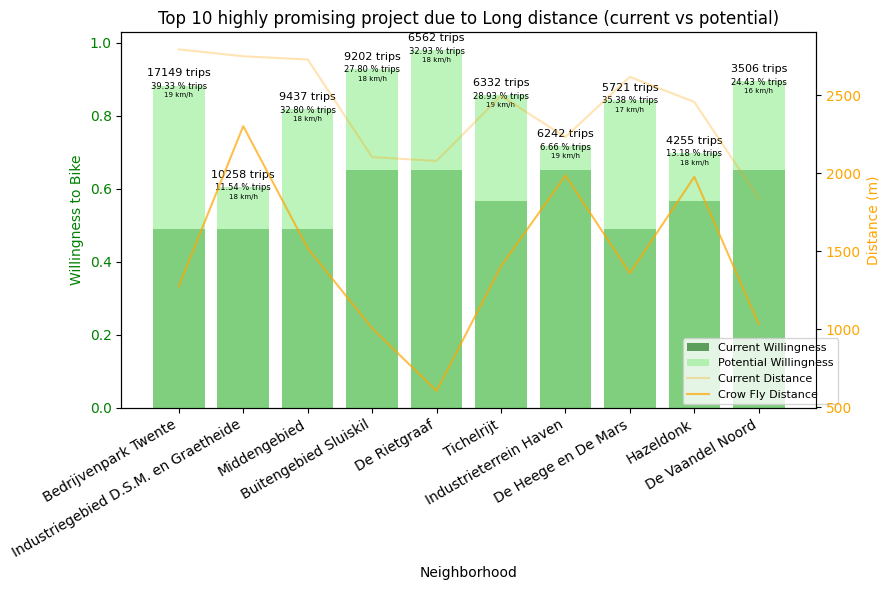

In [992]:
highly_promising_distance_10 = buurt_map[(buurt_map['reason'] == '5')].sort_values(by='increasing_trips_day', ascending=False).drop_duplicates('bu_code').head(10)

# plot the current willingness and willingness upper bound to bike to bus stop for the top 10 neighborhoods with the highest influencing trips with left y-axis
# plot the speed to bike to bus stop for the top 10 neighborhoods with the highest influencing trips with right y-axis
fig, ax1 = plt.subplots(figsize=(9, 6))
# Plot current willingness and upper bound willingness
ax1.bar(highly_promising_distance_10['bu_code'], highly_promising_distance_10['willingness_bus_current'], color='darkgreen', alpha=0.6, label='Current Willingness')
ax1.bar(highly_promising_distance_10['bu_code'], highly_promising_distance_10['potential_willingness'], color='lightgreen', alpha=0.6, label='Potential Willingness')
# Set labels and title for the left y-axis
ax1.set_xlabel('Neighborhood')
ax1.set_ylabel('Willingness to Bike', color='green')
ax1.tick_params(axis='y', labelcolor='green')
# Create a second y-axis for current speed
ax2 = ax1.twinx()
ax2.plot(highly_promising_distance_10['bu_code'], highly_promising_distance_10['reisafstand_m_bus'], color='orange', alpha=0.3, label='Current Distance')
ax2.plot(highly_promising_distance_10['bu_code'], highly_promising_distance_10['afstand_hemelsbreed_m_bus'], color='orange', alpha=0.7, label='Crow Fly Distance')
# Set labels for the right y-axis
ax2.set_ylabel('Distance (m)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


# #add influencing trips as text on the bars
for i, row in highly_promising_distance_10.iterrows():
    ax1.text(row['bu_code'], row['potential_willingness'] + 0.02, f"{row['increasing_trips_day']:.0f} trips", ha='center', va='bottom', fontsize=8, color='black'),
    ax1.text(row['bu_code'], row['potential_willingness'] - 0.015, f"{(row['increasing_trips_perct']):.2f} % trips", ha='center', va='bottom', fontsize=6, color='black'),
    ax1.text(row['bu_code'], row['potential_willingness'] - 0.035, f"{row['speed_bus_bike_km_hour']:.0f} km/h", ha='center', va='bottom', fontsize=5, color='black'),

# change the x-axis labels to be more readable
ax1.set_xticklabels(highly_promising_distance_10['bu_naam'], rotation=30, ha='right')



# Add a title and legend
plt.title('Top 10 highly promising project due to Long distance (current vs potential)')
plt.xticks(rotation=45)
plt.tight_layout()
# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, bbox_to_anchor=(0.8, 0.2), fontsize=8)
plt.show()


explaining graph: for example (the first bar)
current speed is 18.633km/h, distance is more than 2795 meters after improvement, the distacne is 1277, the numeber of trips increased is 17149 per day, with 39.33% increasement.

- most promising project due to long distance (number)

In [989]:
highly_promising_distance_10[['id', 'bu_code', 'bu_naam',
	'willingness_bus_current',
	'willingness_increase',
	'potential_willingness',
	'reisafstand_m_bus',
	'afstand_hemelsbreed_m_bus',
	'speed_bus_bike_km_hour',
	'influencing_trips_day',
	'increasing_trips_day',
    'increasing_trips_perct',
	'reason'
]]

,id,bu_code,bu_naam,willingness_bus_current,willingness_increase,potential_willingness,reisafstand_m_bus,afstand_hemelsbreed_m_bus,speed_bus_bike_km_hour,influencing_trips_day,increasing_trips_day,increasing_trips_perct,reason
7222,1340,BU01411205,Bedrijvenpark Twente,0.489678,0.393325,0.883004,2795.0,1277.0,18.633333,43600.20000,17149.054570,39.332514,5
11962,12044,BU18830507,Industriegebied D.S.M. en Graetheide,0.489678,0.115414,0.605092,2751.0,2303.0,18.340000,88881.80000,10258.183381,11.541377,5
1771,534,BU00500007,Middengebied,0.489678,0.327981,0.817659,2730.0,1520.0,18.200000,28774.51640,9437.495043,32.798101,5
10078,7798,BU07151601,Buitengebied Sluiskil,0.650314,0.277968,0.928281,2104.0,1007.0,18.034286,33106.06488,9202.412012,27.796756,5
12301,11561,BU17340703,De Rietgraaf,0.650314,0.329292,0.979606,2080.0,605.0,17.828571,19928.55200,6562.312582,32.929199,5
14384,8190,BU07660114,Tichelrijt,0.566806,0.289254,0.856060,2497.0,1405.0,18.727500,21891.80000,6332.296895,28.925428,5
11139,9290,BU08670010,Industrieterrein Haven,0.650314,0.066572,0.716886,2233.0,1986.0,19.140000,93762.79472,6242.012806,6.657238,5
344,1091,BU01091013,De Heege en De Mars,0.489678,0.353773,0.843451,2619.0,1360.0,17.460000,16170.00000,5720.504301,35.377268,5
9584,8132,BU07580506,Hazeldonk,0.566806,0.131845,0.698651,2458.0,1978.0,18.435000,32276.05640,4255.433846,13.184491,5
14237,14287,BU19802005,De Vaandel Noord,0.650314,0.244324,0.894638,1839.0,1033.0,15.762857,14348.05680,3505.573904,24.432395,5


businees park to

Due to lack of information on the distance of traveling from business park to nearest public transport station (train, bus). we consider using a radius to approximate the accessbility of business park (1397m for 5.4 mins, speed of 18km/h average speed from bus_naar_buurts, 80% willingness reachable with a detour factor of 1.16.  average deour factor of bus_naar_buurts of nearest combination) <br>
the graph shows that almost every business park is within 80% willingness bike distance. Thus we what matters to people who go work or come home from work to use bike is the modal of traveling from public transport station to neighborhood back and forth as discussed above.

D:\temp\ipykernel_22476\2488540256.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower right', fontsize='small')


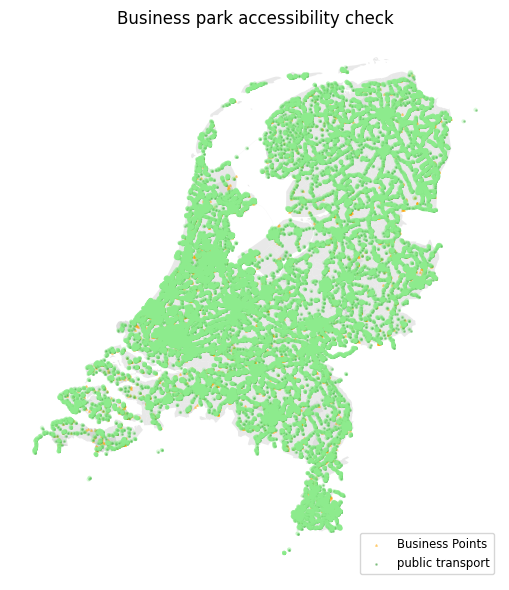

In [995]:
# plot the business points on the buurt_map
plt.figure(figsize=(8, 6))
buurt_map.plot(ax=plt.gca(), color='lightgray', alpha=0.5)
business_points.plot(ax=plt.gca(), color='orange', marker='^', markersize=1, label='Business Points', alpha=0.5)

# plot bus station
bus_centroids.plot(ax=plt.gca(), color='green', markersize=1, label='public transport', alpha=0.3)

# add buffer to bus stations
bus_buffers = bus_centroids.copy()
bus_buffers['geometry'] = bus_buffers.geometry.buffer(1397)  # 1397 meters
bus_buffers.plot(ax=plt.gca(), color='lightgreen', alpha=0.3, label='Bus Station Buffer (1397m)')

#add train buffers
train_buffers = train_centroids.copy()
train_buffers['geometry'] = train_buffers.geometry.buffer(1905)  # 1905 meters
train_buffers.plot(ax=plt.gca(), color='lightgreen', alpha=0.3, label='Train Station Buffer (1905m)')

plt.title("Business park accessibility check")
plt.axis('off')
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


#### constraints and future research
- problem is that all the distance is calculated by the controids distance (neighborhoods centroids to bus stop, train station), instead of true coverage of public transportation, this leads to inaccuracy when calculating residents traveling distance, and willingness to bike.
- the willingness to bike is not realisticly reflected by traveling time, because when the distance is adequatedly low, people tend to walking instead of biking, supported by the content of topic 2.
- We only considered traveling time due to low speed and long distance, but not the quality of bike routes and other factors may also play important role for people's willingness to bike.